In [1]:
#The Essentials

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from interpolation import interp
from numba import njit, prange


In [9]:
@njit
def brent_max(func, a, b, args=(), xtol=1e-5, maxiter=500):
    """
    Uses a jitted version of the maximization routine from SciPy's fminbound.
    The algorithm is identical except that it's been switched to maximization
    rather than minimization, and the tests for convergence have been stripped
    out to allow for jit compilation.
    Note that the input function `func` must be jitted or the call will fail.
    Parameters
    ----------
    func : jitted function
    a : scalar
        Lower bound for search
    b : scalar
        Upper bound for search
    args : tuple, optional
        Extra arguments passed to the objective function.
    maxiter : int, optional
        Maximum number of iterations to perform.
    xtol : float, optional
        Absolute error in solution `xopt` acceptable for convergence.
    Returns
    -------
    xf : float
        The maximizer
    fval : float
        The maximum value attained
    info : tuple
        A tuple of the form (status_flag, num_iter).  Here status_flag
        indicates whether or not the maximum number of function calls was
        attained.  A value of 0 implies that the maximum was not hit.
        The value `num_iter` is the number of function calls.
    Example
    -------
    ```
        @njit
        def f(x):
            return -(x + 2.0)**2 + 1.0
        xf, fval, info = brent_max(f, -2, 2)
    ```
    """
    if not np.isfinite(a):
        raise ValueError("a must be finite.")

    if not np.isfinite(b):
        raise ValueError("b must be finite.")

    if not a < b:
        raise ValueError("a must be less than b.")

    maxfun = maxiter
    status_flag = 0

    sqrt_eps = np.sqrt(2.2e-16)
    golden_mean = 0.5 * (3.0 - np.sqrt(5.0))

    fulc = a + golden_mean * (b - a)
    nfc, xf = fulc, fulc
    rat = e = 0.0
    x = xf
    fx = -func(x, *args)
    num = 1

    ffulc = fnfc = fx
    xm = 0.5 * (a + b)
    tol1 = sqrt_eps * np.abs(xf) + xtol / 3.0
    tol2 = 2.0 * tol1

    while (np.abs(xf - xm) > (tol2 - 0.5 * (b - a))):
        golden = 1
        # Check for parabolic fit
        if np.abs(e) > tol1:
            golden = 0
            r = (xf - nfc) * (fx - ffulc)
            q = (xf - fulc) * (fx - fnfc)
            p = (xf - fulc) * q - (xf - nfc) * r
            q = 2.0 * (q - r)
            if q > 0.0:
                p = -p
            q = np.abs(q)
            r = e
            e = rat

            # Check for acceptability of parabola
            if ((np.abs(p) < np.abs(0.5*q*r)) and (p > q*(a - xf)) and
                    (p < q * (b - xf))):
                rat = (p + 0.0) / q
                x = xf + rat

                if ((x - a) < tol2) or ((b - x) < tol2):
                    si = np.sign(xm - xf) + ((xm - xf) == 0)
                    rat = tol1 * si
            else:      # do a golden section step
                golden = 1

        if golden:  # Do a golden-section step
            if xf >= xm:
                e = a - xf
            else:
                e = b - xf
            rat = golden_mean*e

        if rat == 0:
            si = np.sign(rat) + 1
        else:
            si = np.sign(rat)

        x = xf + si * np.maximum(np.abs(rat), tol1)
        fu = -func(x, *args)
        num += 1

        if fu <= fx:
            if x >= xf:
                a = xf
            else:
                b = xf
            fulc, ffulc = nfc, fnfc
            nfc, fnfc = xf, fx
            xf, fx = x, fu
        else:
            if x < xf:
                a = x
            else:
                b = x
            if (fu <= fnfc) or (nfc == xf):
                fulc, ffulc = nfc, fnfc
                nfc, fnfc = x, fu
            elif (fu <= ffulc) or (fulc == xf) or (fulc == nfc):
                fulc, ffulc = x, fu

        xm = 0.5 * (a + b)
        tol1 = sqrt_eps * np.abs(xf) + xtol / 3.0
        tol2 = 2.0 * tol1

        if num >= maxfun:
            status_flag = 1
            break

    fval = -fx
    info = status_flag, num

    return xf, fval, info

In [10]:
# #White Noise
# mean = 0
# std = 1 
# num_samples = 1
# samples = np.random.normal(mean, std, size=num_samples)

In [29]:
#Optimal Growth Model Class
class OptimalGrowthModel:

    def __init__(self,
                 f,                # Production function
                 u,                # Utility function
                 β=0.96,           # Discount factor
                 μ=0,
                 s=0.1,
                 gamma=0.5,
                 grid_max=4,
                 grid_size=200,
                 shock_size=250):

        self.β, self.μ, self.s = β, μ, s,gamma
        self.f, self.u = f, u

        self.y_grid = np.linspace(1e-5, grid_max, grid_size)       # Set up grid
        self.shocks = np.random.randn(shock_size)  # Store shocks

In [31]:
def operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Bellman operator, as well as
    a function that computes greedy policies.
    
    Here og is an instance of OptimalGrowthModel.
    """

    f, u, β = og.f, og.u, og.β
    y_grid, shocks = og.y_grid, og.shocks

    @njit
    def objective(c, v, y):
        """
        The right hand side of the Bellman equation
        """
        # First turn v into a function via interpolation
        v_func = lambda x: interp(y_grid, v, x)
        return u(c) + β * np.mean(v_func(f(y - c) * shocks))

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """
        v_new = np.empty_like(v)
        for i in prange(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal v at y
            v_max = brent_max(objective, 1e-10, y, args=(v, y))[1]  
            v_new[i] = v_max
        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        σ = np.empty_like(v)
        for i in range(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal c at y
            c_max = brent_max(objective, 1e-10, y, args=(v, y))[0]  
            σ[i] = c_max
        return σ

    return T, get_greedy

In [13]:
# This needs work
def σ_star(y, α, β,gamma):
    """
    True optimal policy
    """
    return ((1 - α * β)^(1/gamma)) * y

def v_star(y, α, β, μ,gamma):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [14]:
α = 0.4  # Production function parameter

@njit
def f(k):
    """
    Cobb-Douglas production function
    """
    return k**α

In [15]:
og = OptimalGrowthModel(f=f, u=np.log)

In [16]:
T, get_greedy = operator_factory(og)

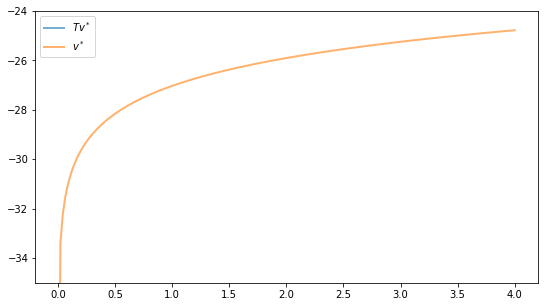

In [17]:
y_grid = og.y_grid
β, μ = og.β, og.μ

v_init = v_star(y_grid, α, β, μ)  # Start at the solution
v = T(v_init)                     # Apply the Bellman operator once

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(y_grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(y_grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()
plt.show()

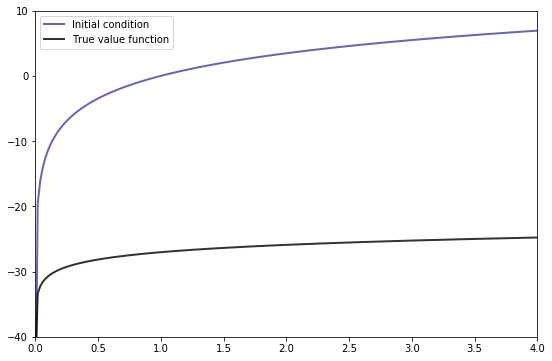

In [24]:
v = 5 * np.log(y_grid)  # An initial condition
n = 100

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(y_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v = T(v)  # Apply the Bellman operator
    ax.plot(y_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(y_grid, v_star(y_grid, α, β, μ), 'k-', lw=2,
        alpha=0.8, label='True value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(y_grid), np.max(y_grid)))
plt.show()

Error at iteration 25 is 4.412461313027279.
Error at iteration 50 is 1.5902365704782824.
Error at iteration 75 is 0.5731160390279797.
Error at iteration 100 is 0.20654913884447978.
Error at iteration 125 is 0.07443963150950594.
Error at iteration 150 is 0.026827798800638902.
Error at iteration 175 is 0.009668650608603002.
Error at iteration 200 is 0.0034845499362745613.
Error at iteration 225 is 0.0012558203572439197.
Error at iteration 250 is 0.00045259353368010125.
Error at iteration 275 is 0.00016311322406181716.

Converged in 287 iterations.


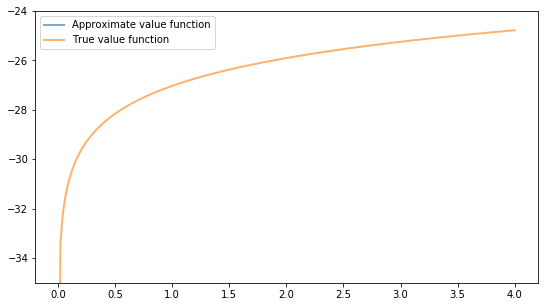

In [26]:
def solve_model(og,
                use_parallel=True,
                tol=1e-4, 
                max_iter=1000, 
                verbose=True,
                print_skip=25): 

    T, _ = operator_factory(og, parallel_flag=use_parallel)

    # Set up loop
    v = np.log(og.y_grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return v_new


v_solution = solve_model(og)

fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(y_grid, v_solution, lw=2, alpha=0.6,
        label='Approximate value function')

ax.plot(y_grid, v_star(y_grid, α, β, μ), lw=2,
        alpha=0.6, label='True value function')

ax.legend()
ax.set_ylim(-35, -24)
plt.show()

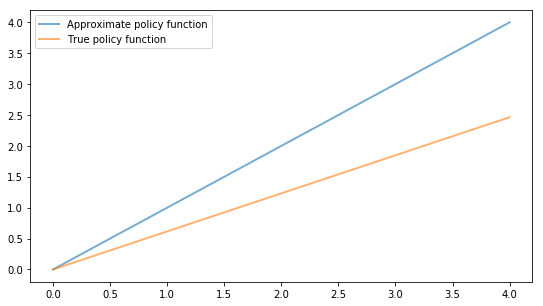

In [27]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(y_grid, get_greedy(v_solution), lw=2,
        alpha=0.6, label='Approximate policy function')

ax.plot(y_grid, σ_star(y_grid, α, β),
        lw=2, alpha=0.6, label='True policy function')

ax.legend()
plt.show()